# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные находятся [здесь](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке: 

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке. 
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [2]:
%pip install tqdm pandarallel transformers wordcloud

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd

from tqdm.notebook import tqdm
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

import transformers
import numpy as np
import torch

from wordcloud import WordCloud
import matplotlib.pyplot as plt

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [5]:
ORIGINAL_DIR = './original'

## Подготовка данных разметки

In [6]:
crowd_annotations = pd.read_csv(f'{ORIGINAL_DIR}/CrowdAnnotations.tsv', delimiter='\t', header=None)
crowd_annotations.columns = ['image', 'query_id', 'percent', 'positive', 'negative']

In [7]:
expert_annotations = pd.read_csv(f'{ORIGINAL_DIR}/ExpertAnnotations.tsv', delimiter='\t', header=None)
expert_annotations.columns = ['image', 'query_id', 'expert_0', 'expert_1', 'expert_2']

In [8]:
def get_expert(record):
    marks = [0, 0, 0, 0]
     
    marks[record['expert_0'] - 1] += 1
    marks[record['expert_1'] - 1] += 1
    marks[record['expert_2'] - 1] += 1

    for i in range(len(marks)):
        if (marks[i] == 2) | (marks[i] == 3):
            return i + 1

    return 0

expert_annotations['mark'] = expert_annotations.apply(get_expert, axis=1)

In [9]:
expert_annotations = expert_annotations[expert_annotations['mark'] > 0]

In [10]:
expert_annotations['percent_expert'] = expert_annotations['mark'] / 4

In [11]:
expert_annotations

,image,query_id,expert_0,expert_1,expert_2,mark,percent_expert
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1,0.25
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1,0.25
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1,0.25
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,2,0.50
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1,0.25
...,...,...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1,1,0.25
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1,1,0.25
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2,1,0.25
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1,1,0.25


In [12]:
crowd_annotations['sum'] = crowd_annotations['positive'] + crowd_annotations['negative']

In [13]:
crowd_annotations['percent_crowd'] = crowd_annotations['positive'] / crowd_annotations['sum']

In [14]:
crowd_annotations

,image,query_id,percent,positive,negative,sum,percent_crowd
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0,3,1.000000
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3,3,0.000000
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3,3,0.000000
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3,3,0.000000
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3,3,0.000000
...,...,...,...,...,...,...,...
47825,997722733_0cb5439472.jpg,543007912_23fc735b99.jpg#2,0.000000,0,3,3,0.000000
47826,997722733_0cb5439472.jpg,544576742_283b65fa0d.jpg#2,0.333333,1,2,3,0.333333
47827,997722733_0cb5439472.jpg,872622575_ba1d3632cc.jpg#2,1.000000,3,0,3,1.000000
47828,997722733_0cb5439472.jpg,888425986_e4b6c12324.jpg#2,0.000000,0,3,3,0.000000


In [15]:
expert_annotations

,image,query_id,expert_0,expert_1,expert_2,mark,percent_expert
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1,0.25
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1,0.25
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1,0.25
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,2,0.50
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1,0.25
...,...,...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1,1,0.25
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1,1,0.25
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2,1,0.25
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1,1,0.25


In [16]:
marks = crowd_annotations.merge(expert_annotations, on=['query_id', 'image'])[['image', 'query_id', 'percent_crowd', 'percent_expert']]

## Данные о фотографиях.

In [17]:
test_images = pd.read_csv(f'{ORIGINAL_DIR}/test_images.csv')
test_queries = pd.read_csv(f'{ORIGINAL_DIR}/test_queries.csv', delimiter='|', index_col=[0])
train_dataset = pd.read_csv(f'{ORIGINAL_DIR}/train_dataset.csv')

In [18]:
test_images.sample(10)

,image
34,2597308074_acacc12e1b.jpg
8,2977379863_2e8d7a104e.jpg
61,3690425778_3b390b3ea5.jpg
80,1991806812_065f747689.jpg
55,3211199368_ca78387f72.jpg
83,2505056124_1276e8dbcb.jpg
21,3330333217_1a69497a74.jpg
73,2737233999_34d60dc5c3.jpg
19,3653484549_f316590b0f.jpg
26,989754491_7e53fb4586.jpg


In [19]:
test_queries.sample(10)

,query_id,query_text,image
229,3091962081_194f2f3bd4.jpg#4,The man is dressed in black and smiling while ...,3091962081_194f2f3bd4.jpg
31,1580671272_3e99d94305.jpg#1,A man feeding a horse wearing a blue strapped ...,1580671272_3e99d94305.jpg
413,3690425778_3b390b3ea5.jpg#3,The boy jumps into the water off of a dock .,3690425778_3b390b3ea5.jpg
261,3173157541_70b16b4318.jpg#1,"A man with a white hat and brown shirt , behin...",3173157541_70b16b4318.jpg
222,3089107423_81a24eaf18.jpg#2,A man is videotaping something .,3089107423_81a24eaf18.jpg
490,989754491_7e53fb4586.jpg#0,A girl in a pool wearing goggles and surrounde...,989754491_7e53fb4586.jpg
9,1232148178_4f45cc3284.jpg#4,There is a little blond hair girl with a green...,1232148178_4f45cc3284.jpg
487,973827791_467d83986e.jpg#2,A woman is throwing a bucket of water over a b...,973827791_467d83986e.jpg
149,2670637584_d96efb8afa.jpg#4,The woman with binoculars is sitting on the fo...,2670637584_d96efb8afa.jpg
255,3170110692_d1e0e66cee.jpg#0,a couple each wearing a silly mask and holding...,3170110692_d1e0e66cee.jpg


In [20]:
train_dataset.sample(10)

,image,query_id,query_text
3170,3624327440_bef4f33f32.jpg,421730441_6b2267fd31.jpg#2,A man standing in front of a brick building .
4368,2862004252_53894bb28b.jpg,1267711451_e2a754b4f8.jpg#2,a black and white dog walking through the gras...
2848,2933912528_52b05f84a1.jpg,3642220260_3aa8a52670.jpg#2,A black dog walks on the beach near the rocks .
3676,2086513494_dbbcb583e7.jpg,317383917_d8bfa350b6.jpg#2,three black dogs and a white dog are standing ...
4741,3162045919_c2decbb69b.jpg,3071676551_a65741e372.jpg#2,A surfer is riding a wave .
4277,2510020918_b2ca0fb2aa.jpg,758921886_55a351dd67.jpg#2,A little girl is sliding down a tunnel smiling .
666,1220401002_3f44b1f3f7.jpg,1119015538_e8e796281e.jpg#2,A small dogs ears stick up as it runs in the g...
2828,160792599_6a7ec52516.jpg,2559921948_06af25d566.jpg#2,a little boy at the beach with a surfboard
3574,473220329_819a913bbb.jpg,1509786421_f03158adfc.jpg#2,A boy smiles at points at something ; a man lo...
166,136644343_0e2b423829.jpg,2472980433_210ec62874.jpg#2,A man riding a motorcycle is performing a tric...


In [21]:
test_images.info()
print()
test_queries.info()
print()
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [22]:
len(test_queries['image'].unique())

100

In [23]:
len(train_dataset['image'].unique())

1000

In [24]:
test_queries['type'] = 'test'
train_dataset['type'] = 'train'
data = pd.concat([test_queries, train_dataset]).reset_index(drop=True)

In [25]:
len(data['image'].unique())

1100

Проверим test_images и test_queries, соответствуют ли данные, если да то test_images не нужны.

In [26]:
test_queries[test_queries['image'].isin(test_images['image'])]

,query_id,query_text,image,type
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg,test
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg,test
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg,test
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg,test
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg,test
...,...,...,...,...
495,989851184_9ef368e520.jpg#0,A black dog has a dumbbell in his mouth .,989851184_9ef368e520.jpg,test
496,989851184_9ef368e520.jpg#1,A black dog has a dumbbell in his mouth lookin...,989851184_9ef368e520.jpg,test
497,989851184_9ef368e520.jpg#2,A black dog holding a weight in its mouth stan...,989851184_9ef368e520.jpg,test
498,989851184_9ef368e520.jpg#3,A black dog holds a small white dumbbell in it...,989851184_9ef368e520.jpg,test


In [27]:
test_images[test_images['image'].isin(test_queries['image'].unique())]

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg
...,...
95,2431120202_b24fe2333a.jpg
96,2399219552_bbba0a9a59.jpg
97,3091962081_194f2f3bd4.jpg
98,2670637584_d96efb8afa.jpg


Значит датасеты совпадают

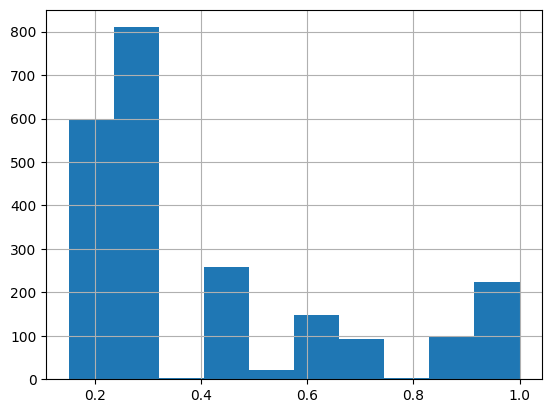

In [28]:
def get_mark(record):
    return record['percent_crowd'] * 0.4 + record['percent_expert'] * 0.6

marks['target'] = marks.apply(get_mark, axis=1)
marks['target'].hist()
None

In [29]:
data['type'].value_counts()

type
train    5822
test      500
Name: count, dtype: int64

In [30]:
df = marks.merge(data, on=['query_id', 'image'], how='right')
df.sample(10)

,image,query_id,percent_crowd,percent_expert,target,query_text,type
5342,540721368_12ac732c6c.jpg,244571201_0339d8e8d1.jpg#2,NaN,NaN,NaN,Five dogs are swimming and four people are wad...,train
3016,1772859261_236c09b861.jpg,3498327617_d2e3db3ee3.jpg#2,0.333333,0.75,0.583333,a grey dog swimming through a river with a sti...,train
3717,1836335410_de8313a64e.jpg,2602085456_d1beebcb29.jpg#2,NaN,NaN,NaN,A topless woman is covered in mud .,train
332,3435015880_eda46ff50f.jpg,3435015880_eda46ff50f.jpg#2,NaN,NaN,NaN,Two people are running at the top of a mountain .,test
11,123997871_6a9ca987b1.jpg,123997871_6a9ca987b1.jpg#1,NaN,NaN,NaN,Several female lacrosse players are going afte...,test
6017,3456362961_d8f7e347a8.jpg,1808370027_2088394eb4.jpg#2,0.000000,0.25,0.150000,A yellow dog swims towards a waterfall .,train
2111,400851260_5911898657.jpg,3567061016_62768dcce1.jpg#2,NaN,NaN,NaN,A bird with its wings spread,train
4297,525863257_053333e612.jpg,3610683688_bbe6d725ed.jpg#2,0.333333,0.50,0.433333,A dog wading into the water,train
3770,2667015110_1670324a33.jpg,1224851143_33bcdd299c.jpg#2,NaN,NaN,NaN,A little boy is eating his food off of a spoon...,train
134,2517284816_9b8fd3c6b6.jpg,2517284816_9b8fd3c6b6.jpg#4,NaN,NaN,NaN,Middle school aged kids are showing their scho...,test


In [31]:
df = df[(~df['percent_crowd'].isna()) | (df['type'] == 'test')]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2758 entries, 0 to 6320
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           2758 non-null   object 
 1   query_id        2758 non-null   object 
 2   percent_crowd   2258 non-null   float64
 3   percent_expert  2258 non-null   float64
 4   target          2258 non-null   float64
 5   query_text      2758 non-null   object 
 6   type            2758 non-null   object 
dtypes: float64(3), object(4)
memory usage: 172.4+ KB


## Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
> 

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

## Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [32]:
MAX_LENGTH = max(df['query_text'].apply(lambda x: len(x)))
print(MAX_LENGTH)

153


In [33]:
tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')

illegal_ids = tokenizer.encode(
    ' '.join(['boy', 'boys', 'girl', 'girls', 'young', 'child', 'children']), 
    truncation=True, 
    max_length=MAX_LENGTH, 
    add_special_tokens=True
)

def tokenize(text, tokenizer, max_length, illegal_ids):
    ids = tokenizer.encode(
        text, 
        truncation=True, 
        max_length=max_length, 
        add_special_tokens=True
    )
    print(ids, illegal_ids)
    if len(list(set(ids) & set(illegal_ids))) == 2:
        return ids
    else:
        return None

def get_padded_mask(tokenized):
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    attention_mask = np.where(padded != 0, 1, 0)

    padded = torch.LongTensor(padded)  
    attention_mask = torch.LongTensor(attention_mask)

    return padded, attention_mask

In [34]:
tokenized = df['query_text'].parallel_apply(tokenize, tokenizer=tokenizer, max_length=MAX_LENGTH, illegal_ids=illegal_ids)

tokenized = tokenized.dropna()

padded, attention_mask = get_padded_mask(tokenized)


In [35]:
df = df.loc[tokenized.index]
df['input_ids'] = padded.tolist()
df['attention_mask'] = attention_mask.tolist()

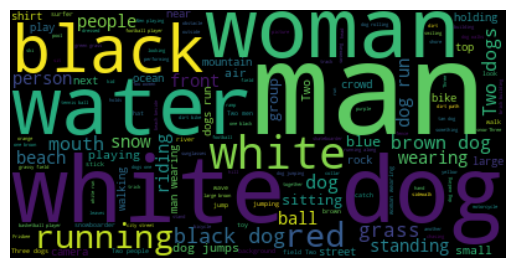

In [36]:
wordcloud = WordCloud().generate(' '.join(df['query_text']))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [37]:
df = df.reset_index(drop=True)

In [38]:
df

,image,query_id,percent_crowd,percent_expert,target,query_text,type,input_ids,attention_mask
0,123997871_6a9ca987b1.jpg,123997871_6a9ca987b1.jpg#1,NaN,NaN,NaN,Several female lacrosse players are going afte...,test,"[101, 2195, 2931, 13488, 2867, 2024, 2183, 204...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."
1,123997871_6a9ca987b1.jpg,123997871_6a9ca987b1.jpg#3,NaN,NaN,NaN,The woman lacrosse player in blue is about to ...,test,"[101, 1996, 2450, 13488, 2447, 1999, 2630, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,123997871_6a9ca987b1.jpg,123997871_6a9ca987b1.jpg#4,NaN,NaN,NaN,Women play lacrosse .,test,"[101, 2308, 2377, 13488, 1012, 102, 0, 0, 0, 0...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1319634306_816f21677f.jpg,1319634306_816f21677f.jpg#0,NaN,NaN,NaN,A brown dog is sitting in some long grass .,test,"[101, 1037, 2829, 3899, 2003, 3564, 1999, 2070...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."
4,1319634306_816f21677f.jpg,1319634306_816f21677f.jpg#1,NaN,NaN,NaN,A brown dog sits still on a hillside .,test,"[101, 1037, 2829, 3899, 7719, 2145, 2006, 1037...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...
2103,415793623_6c1225ae27.jpg,2554081584_233bdf289a.jpg#2,0.0,0.50,0.30,a man wearing a yellow shirt and white hardhat...,train,"[101, 1037, 2158, 4147, 1037, 3756, 3797, 1998...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2104,476759700_8911f087f8.jpg,1082379191_ec1e53f996.jpg#2,0.0,0.25,0.15,A man and a woman sitting on a dock .,train,"[101, 1037, 2158, 1998, 1037, 2450, 3564, 2006...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."
2105,561417861_8e25d0c0e8.jpg,410453140_5401bf659a.jpg#2,0.0,0.50,0.30,A man stands at the entrance of Yerba Buena Ce...,train,"[101, 1037, 2158, 4832, 2012, 1996, 4211, 1997...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2106,561940436_64d6fc125d.jpg,3157847991_463e006a28.jpg#2,0.0,0.25,0.15,Two men in black jackets behind a white handra...,train,"[101, 2048, 2273, 1999, 2304, 17764, 2369, 103...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."


## Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [39]:
import torch
from PIL import Image
from transformers import AutoFeatureExtractor, ResNetForImageClassification
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [40]:
images = df['image'].unique()
len(images)

855

In [41]:


# datagen = ImageDataGenerator() 

# datagen_flow = datagen.flow_from_directory(
#     # папка, в которой хранится датасет
#     f'{ORIGINAL_DIR}/images/',
#     # к какому размеру приводить изображения
#     target_size=(150, 150), 
#     # размер батча
#     batch_size=16,
#     # в каком виде выдавать метки классов
#     class_mode='sparse',
#     # фиксируем генератор случайных чисел (от англ. random seed)
#     seed=12345
# ) 

Found 0 images belonging to 0 classes.


c:\Users\Kirill\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\convnext\feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


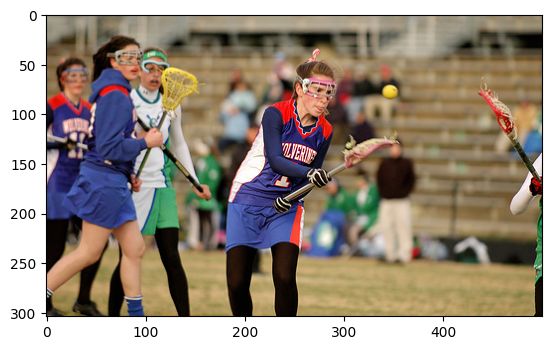

In [42]:
image = Image.open(f'{ORIGINAL_DIR}/images/{images[0]}')
plt.imshow(np.array(image)) 

In [60]:
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-18")

inputs = feature_extractor(image, return_tensors="pt")

model = ResNetForImageClassification.from_pretrained("microsoft/resnet-18")

# newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))

with torch.no_grad():
    logits = newmodel(inputs['pixel_values'])

print(logits)
# print(len(.reshape(-1)))
# model predicts one of the 1000 ImageNet classes
# predicted_label = logits.argmax(-1).item()


BaseModelOutputWithPoolingAndNoAttention(last_hidden_state=tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0292],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.3013],
          ...,
          [0.5691, 1.2609, 3.4638,  ..., 1.6147, 0.0000, 0.0000],
          [0.0000, 0.6561, 2.4379,  ..., 0.9844, 0.0000, 0.0000],
          [0.0000, 0.0128, 0.8949,  ..., 0.1622, 0.0000, 0.0000]],

         [[0.0000, 0.6275, 2.4873,  ..., 0.9132, 1.2672, 0.7506],
          [0.0000, 0.5129, 1.5916,  ..., 0.0000, 0.2343, 0.9020],
          [0.9141, 2.3505, 2.5231,  ..., 0.0000, 0.0057, 0.6870],
          ...,
          [0.9512, 1.4716, 2.7856,  ..., 1.3152, 0.6512, 0.0000],
          [0.0000, 0.0000, 0.7723,  ..., 0.1191, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[2.1873, 3.8947, 4.0061,  ..., 3.1184, 4.5317, 2.3860],
          [1.8833, 4.6992, 4.1238,  ..., 2.7816, 

In [ ]:

test_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)

test_gen_flow = test_datagen.flow_from_dataframe(
    dataframe=images[0:16],
    directory=ORIGINAL_DIR + '/images',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345)

features, target = next(test_gen_flow)

## Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

## Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска